![](image.jpg)


Dive into the heart of data science with a project that combines healthcare insights and predictive analytics. As a Data Scientist at a top Health Insurance company, you have the opportunity to predict customer healthcare costs using the power of machine learning. Your insights will help tailor services and guide customers in planning their healthcare expenses more effectively.

## Dataset Summary

Meet your primary tool: the `insurance.csv` dataset. Packed with information on health insurance customers, this dataset is your key to unlocking patterns in healthcare costs. Here's what you need to know about the data you'll be working with:

## insurance.csv
| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |



A bit of data cleaning is key to ensure the dataset is ready for modeling. Once your model is built using the `insurance.csv` dataset, the next step is to apply it to the `validation_dataset.csv`. This new dataset, similar to your training data minus the `charges` column, tests your model's accuracy and real-world utility by predicting costs for new customers.

## Let's Get Started!

This project is your playground for applying data science in a meaningful way, offering insights that have real-world applications. Ready to explore the data and uncover insights that could revolutionize healthcare planning? Let's begin this exciting journey!

In [202]:
# Re-run this cell
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Loading the insurance dataset
insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


Explore data and make sure it looks OK for engineering

In [203]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


In [204]:
# count empty values by field
insurance.isna().sum()

age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     54
dtype: int64

In [205]:
# create new instance to preserve original df
insurance_new = insurance

In [206]:
# count empty values again
insurance_new.isna().sum() # still plenty of empty values for all fields

age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     54
dtype: int64

In [207]:
insurance_new.describe()
# age has negative values
# children has negative values

,age,bmi,children
count,1272.000000,1272.000000,1272.000000
mean,35.214623,30.560550,0.948899
std,22.478251,6.095573,1.303532
min,-64.000000,15.960000,-4.000000
25%,24.750000,26.180000,0.000000
50%,38.000000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


In [208]:
# Inspect string fields
insurance_str = insurance_new[['sex', 'smoker', 'region', 'charges']]
unique_values = {col: insurance_str[col].unique() for col in insurance_str.columns}
print(unique_values)

{'sex': array(['female', 'male', 'woman', 'F', 'man', nan, 'M'], dtype=object), 'smoker': array(['yes', 'no', nan], dtype=object), 'region': array(['southwest', 'Southeast', 'southeast', 'northwest', 'Northwest',
       'Northeast', 'northeast', 'Southwest', nan], dtype=object), 'charges': array(['16884.924', '1725.5523', '$4449.462', ..., '$1629.8335',
       '2007.945', '29141.3603'], dtype=object)}


From inspection of database, the following transformations are due:
- clean fields
- inspect negative values in 'age' and 'children'
- deal with nans

In [209]:
# clean fields - strings first
# sex - replace invalid values
insurance_new['sex'] = insurance_new['sex'].replace({'woman': 'female', 'F': 'female', 'man': 'male', 'M': 'male'})

# region - turn to lowercase
insurance_new['region'] = insurance_new['region'].str.lower()

# charges - turn to float
insurance_new['charges'] = insurance_new['charges'].str.replace('\$', '')
insurance_new['charges'] = insurance_new['charges'].astype('float')

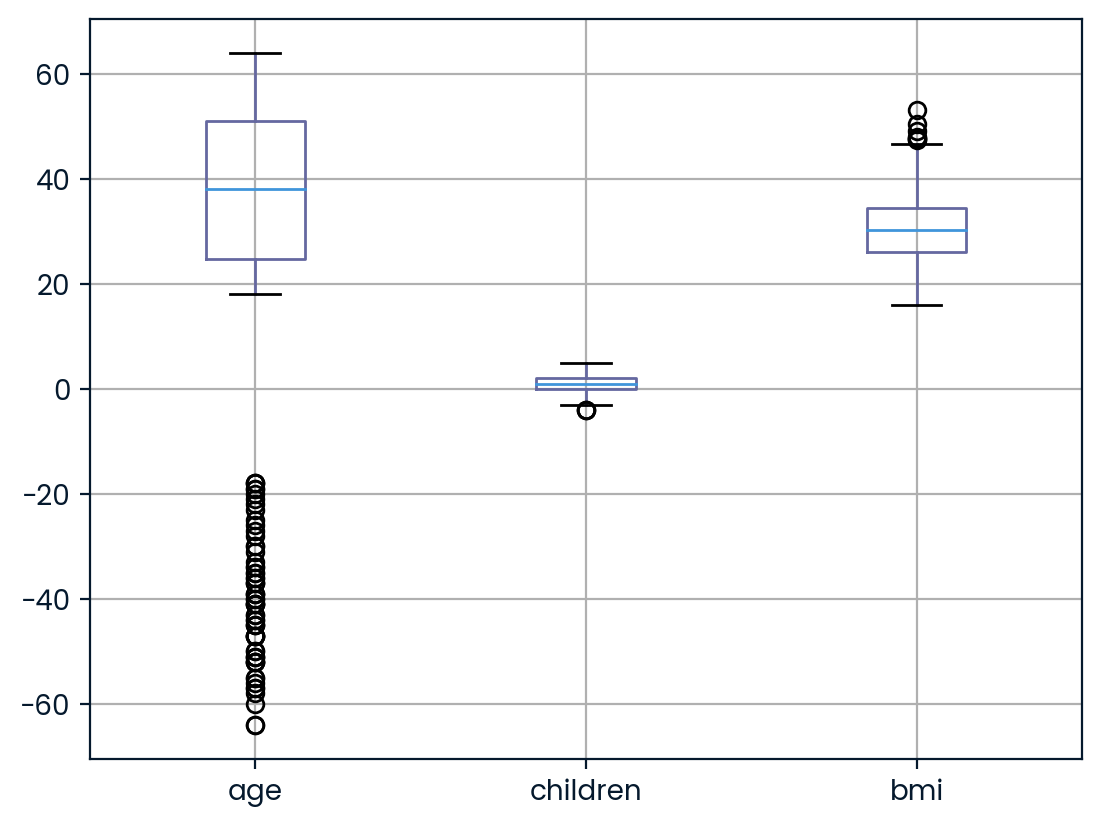

<Figure size 640x480 with 0 Axes>

In [210]:
# clean fields - numeric
# build boxplots to check value distribution
import matplotlib.pyplot as plt

insurance_new.boxplot(column=['age', 'children', 'bmi'])
plt.show()
plt.clf()

In [211]:
# children - turn negative values to 0
insurance_new.loc[insurance_new['children'] < 0, 'children'] = 0

# age - drop negative values
insurance_new = insurance_new[insurance_new['age'] > 0]

# bmi looks OK

In [212]:
# deal with nans
# just drop them - if results are not satisfactory circle back and try something different
insurance_new = insurance_new.dropna()

Data cleaning is complete.
Now create and evaluate regression model.

In [213]:
# Create X and y
X = insurance_new.drop('charges', axis=1)
y = insurance_new['charges']

# Separate categorical (strings) and numerical fields
X_categorical = ['sex', 'region', 'smoker']
X_numerical = ['age', 'children', 'bmi']

# One-hot encode categorical fields
X_dummies = pd.get_dummies(X[X_categorical], drop_first=True)

# Recombine categorical and numerical
X_processed = pd.concat([X[X_numerical], X_dummies], axis=1)
X_processed.head()

,age,children,bmi,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19.0,0.0,27.900,0,0,0,1,1
1,18.0,1.0,33.770,1,0,1,0,0
2,28.0,3.0,33.000,1,0,1,0,0
3,33.0,0.0,22.705,1,1,0,0,0
4,32.0,0.0,28.880,1,1,0,0,0


In [214]:
# Numeric fields are uneven in range - scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

In [215]:
# Create and train the model
#   Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
lr = LinearRegression()

# Create a pipeline
from sklearn.pipeline import Pipeline
steps = [("scaler", scaler), ("lr", lr)]
insurance_pipeline = Pipeline(steps)

# Train model
insurance_pipeline.fit(X_scaled, y)

# Get scores
mse_scores = -cross_val_score(insurance_pipeline, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
r2_scores= cross_val_score(insurance_pipeline, X_scaled, y, cv=5, scoring='r2')
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)
print(mean_mse)
print(mean_r2) # acceptability threshold is 0.65

37431001.52191915
0.7450511466263761


Let's validate with the validation dataset

In [216]:
# Create dataframe
validation_data = pd.read_csv('validation_dataset.csv')

# Check fields
validation_data.head()

,age,sex,bmi,children,smoker,region
0,18.0,female,24.090000,1.0,no,southeast
1,39.0,male,26.410000,0.0,yes,northeast
2,27.0,male,29.150000,0.0,yes,southeast
3,71.0,male,65.502135,13.0,yes,southeast
4,28.0,male,38.060000,0.0,no,southeast


In [217]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     object 
 2   bmi       50 non-null     float64
 3   children  50 non-null     float64
 4   smoker    50 non-null     object 
 5   region    50 non-null     object 
dtypes: float64(3), object(3)
memory usage: 2.5+ KB


In [218]:
# Check unique values for strings
insurance_str = validation_data[['sex', 'smoker', 'region']]
unique_values = {col: insurance_str[col].unique() for col in insurance_str.columns}
print(unique_values) # looks OK

{'sex': array(['female', 'male'], dtype=object), 'smoker': array(['no', 'yes'], dtype=object), 'region': array(['southeast', 'northeast', 'northwest', 'southwest'], dtype=object)}


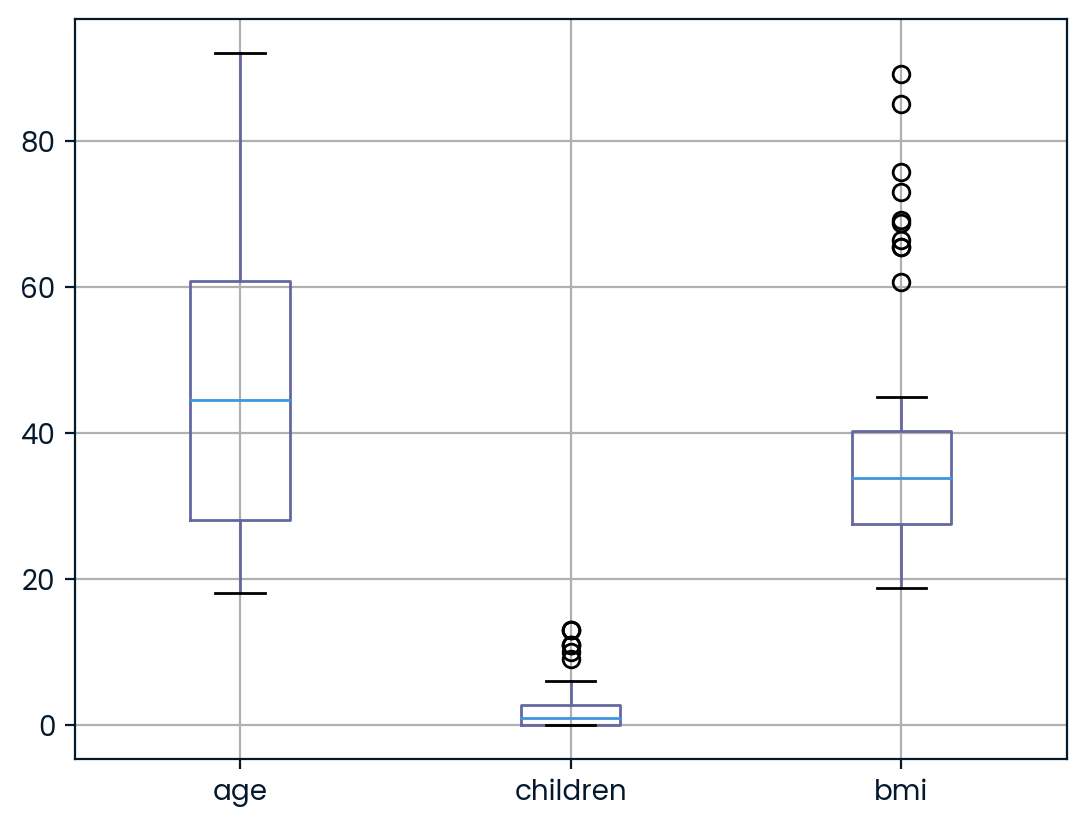

<Figure size 640x480 with 0 Axes>

In [219]:
# Check float fields
validation_data.boxplot(column=['age', 'children', 'bmi']) # looks OK
plt.show()
plt.clf()

In [220]:
# Transform validation to make it apt for fitting
validation_processed = pd.get_dummies(validation_data, columns=['sex', 'region', 'smoker'], drop_first=True)

# Scale validation
validation_scaled = scaler.fit_transform(validation_processed)

# Make predictions using the trained model
validation_predictions = insurance_pipeline.predict(validation_scaled)

# Add predicted charges to the dataframe
validation_data['predicted_charges'] = validation_predictions

# Adjuts to make sure minimum charge is $1000
validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000

# Inspect
validation_data.head()

,age,sex,bmi,children,smoker,region,predicted_charges
0,18.0,female,24.090000,1.0,no,southeast,1000.000000
1,39.0,male,26.410000,0.0,yes,northeast,23523.303548
2,27.0,male,29.150000,0.0,yes,southeast,21787.451336
3,71.0,male,65.502135,13.0,yes,southeast,23836.754712
4,28.0,male,38.060000,0.0,no,southeast,1000.000000
